In [272]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from pathlib import Path
import os

from gluonts.dataset.pandas import PandasDataset
from gluonts.torch import DeepAREstimator
from gluonts.model.predictor import Predictor
from gluonts.time_feature import get_lags_for_frequency

from utils import M5Data

## Data exploration

M5 Forecasting - Accuracy

In [2]:
data_root = "../data/m5-forecasting-accuracy" # Root dir of the M5 dataset

calendar = pd.read_csv(os.path.join(data_root, "calendar.csv"))
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [3]:
test = pd.read_csv(os.path.join(data_root, "sales_train_evaluation.csv"))
test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [20]:
train = pd.read_csv(os.path.join(data_root, "sales_train_validation.csv"))
train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


d_1    32631
d_2    31749
d_3    23783
d_4    25412
d_5    19146
dtype: int64

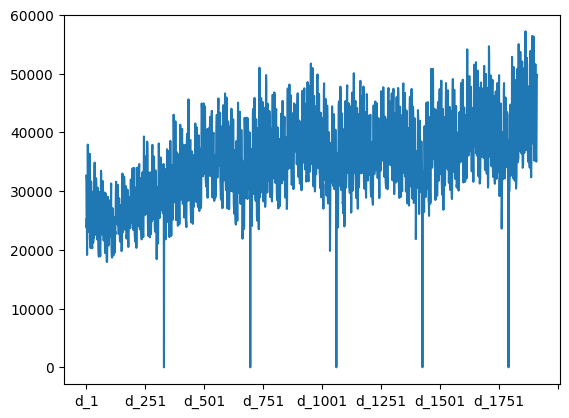

In [23]:
# Ventas totales por día
start_pos = train.columns.get_loc('d_1')

total_sales = train.iloc[:, start_pos:].sum()
total_sales.plot()
total_sales.head()
#total_sales[total_sales < 1000]

In [ ]:
calendar[calendar['d'] == "d_697"]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
696,2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,NaN,NaN,0,0,0


<Axes: >

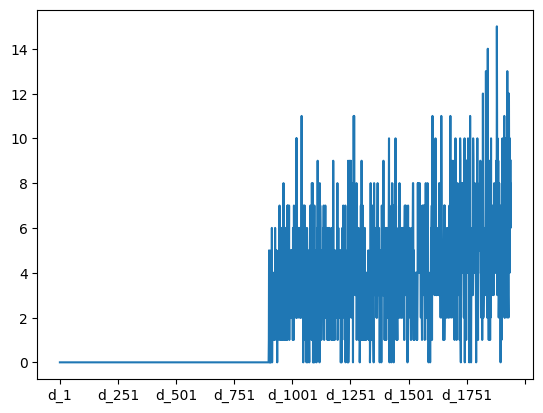

In [ ]:
train[train['item_id'] == "HOBBIES_1_001"].iloc[:, start_pos:].sum().plot()

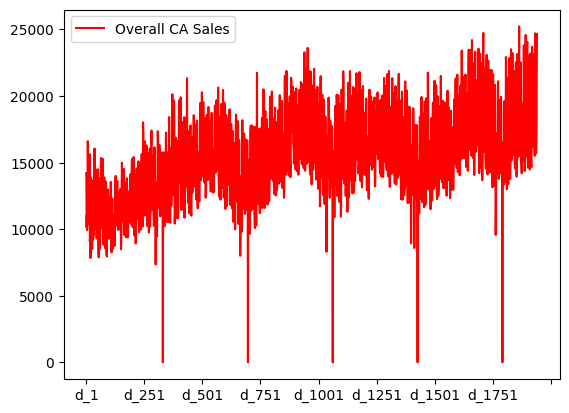

In [ ]:
train[train['state_id'] == "CA"].iloc[:, start_pos:].sum().plot(color="red", label = "Overall CA Sales")
#sales[sales['state_id'] == "TX"].iloc[:, start_pos:].sum().plot(color="blue", label = "Overall TX Sales")
#sales[sales['state_id'] == "WI"].iloc[:, start_pos:].sum().plot(color="green", label = "Overall WI Sales")
plt.legend()

## Data Loading

In [3]:
data_root = "../data/m5-forecasting-accuracy" # Root dir of the M5 dataset
calendar_path = os.path.join(data_root, "calendar.csv")
sales_train_validation_path = os.path.join(data_root, "sales_train_validation.csv")
sales_train_evaluation_path = os.path.join(data_root, "sales_train_evaluation.csv")

In [4]:
m5data = M5Data(calendar_path=calendar_path, 
                sales_train_validation_path=sales_train_validation_path,
                sales_train_evaluation_path=sales_train_evaluation_path)


<Figure size 640x480 with 0 Axes>

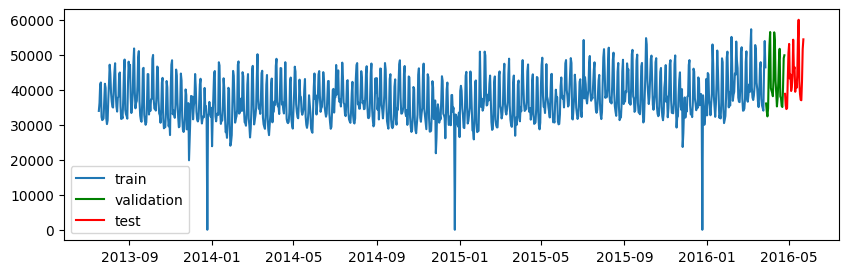

In [263]:
train_sets, cv_sets = m5data.get_train_val_ts(n_splits=1, dynamic_start_pos=True)
test_set = m5data.get_test_ts()
n_splits = len(train_sets)

plt.tight_layout()
if n_splits > 1:
    f, axs = plt.subplots(n_splits, 1, sharex=True)
    axs[0].set_title("Cross Validation Sets")
    for i in range(n_splits):
        train_ts= train_sets[i]
        cv_ts   = cv_sets[i]

        n_days = len(cv_ts)
        dates   = m5data.get_dates(pd.concat([train_ts, cv_ts]), real=True)
        test_dates = m5data.get_dates(test_set, real=True)

        axs[i].plot(dates.values[:-n_days], train_ts.values, label="train")
        axs[i].plot(dates.values[-n_days:], cv_ts.values, color="green", label="validation")
        axs[i].plot(test_dates.values, test_set.values, color="red", label="test")
    plt.legend(loc="upper left")
else:
    train_ts= train_sets[0]
    cv_ts   = cv_sets[0]
    n_days = len(cv_ts)
    dates   = m5data.get_dates(pd.concat([train_ts, cv_ts]), real=True)
    test_dates = m5data.get_dates(test_set, real=True)
    plt.figure(figsize=(10, 3))
    plt.plot(dates.values[:-n_days], train_ts.values, label="train")
    plt.plot(dates.values[-n_days:], cv_ts.values, color="green", label="validation")
    plt.plot(test_dates.values, test_set.values, color="red", label="test")
    plt.legend(loc="lower left")


In [6]:
m5data.sales_train[m5data.sales_train['item_id'] == "FOODS_3_823"]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
3044,FOODS_3_823_CA_1_validation,FOODS_3_823,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,4,0,2,1,0,2,0,4,1,1
6093,FOODS_3_823_CA_2_validation,FOODS_3_823,FOODS_3,FOODS,CA_2,CA,0,0,0,0,...,4,2,1,3,1,3,0,2,2,3
9142,FOODS_3_823_CA_3_validation,FOODS_3_823,FOODS_3,FOODS,CA_3,CA,10,5,4,5,...,2,2,2,3,3,2,3,4,1,0
12191,FOODS_3_823_CA_4_validation,FOODS_3_823,FOODS_3,FOODS,CA_4,CA,1,1,1,4,...,3,1,2,2,0,1,1,3,3,0
15240,FOODS_3_823_TX_1_validation,FOODS_3_823,FOODS_3,FOODS,TX_1,TX,2,2,2,2,...,0,1,0,0,0,0,0,0,1,0
18289,FOODS_3_823_TX_2_validation,FOODS_3_823,FOODS_3,FOODS,TX_2,TX,2,1,0,1,...,0,0,0,0,1,0,0,0,1,0
21338,FOODS_3_823_TX_3_validation,FOODS_3_823,FOODS_3,FOODS,TX_3,TX,0,0,0,0,...,1,1,0,1,0,0,0,2,0,2
24387,FOODS_3_823_WI_1_validation,FOODS_3_823,FOODS_3,FOODS,WI_1,WI,0,0,0,0,...,0,1,2,1,0,0,0,2,0,0
27436,FOODS_3_823_WI_2_validation,FOODS_3_823,FOODS_3,FOODS,WI_2,WI,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1


In [7]:
m5data.sales_train['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

# XGBoost

In [291]:
sales_eval = pd.read_csv(os.path.join(data_root, "sales_train_evaluation.csv"))
sales_eval.head()
start_pos_eval = sales_eval.columns.get_loc('d_1')
total_sales_eval = sales_eval.iloc[:, start_pos_eval:].sum()

sales = pd.read_csv(os.path.join(data_root, "sales_train_validation.csv"))
start_pos = sales.columns.get_loc('d_1')
total_sales = sales.iloc[:, start_pos:].sum()

calendar = pd.read_csv(os.path.join(data_root, "calendar.csv"))
calendar_reduced = calendar.iloc[:1913]
calendar_reduced.head()

#  Crear caracteristicas de la serie temporal
fechas = pd.date_range(start='2011-01-29', periods=len(total_sales), freq="D")
serie = pd.Series(total_sales.values, index=fechas)
data = serie.to_frame(name='total_sales')
data.reset_index(drop=True, inplace=True)
calendar_reduced.reset_index(drop=True, inplace=True)
fecha = pd.to_datetime(calendar_reduced['date'])

data['wday'] = calendar_reduced['wday']
data['day'] = fecha.dt.day
data['month'] = calendar_reduced['month']
data['year'] = calendar_reduced['year']
data['event_name_1'] = calendar_reduced['event_name_1'].notna()
data['event_name_2'] = calendar_reduced['event_name_2'].notna()

Mejor modelo: {'params': {'n_estimators': 270, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 13}, 'rmse': np.float64(1866.3655858378872), 'model': XGBRegressor(alpha=13, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=270, n_jobs=None,
             num_parallel_tree=None, ...)}


/tmp/ipykernel_2315/2519781446.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Cinco De Mayo' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  fechas_futuras.loc[i, 'event_name_1'] = calendar_reduced.loc[1546+i, 'event_name_1']


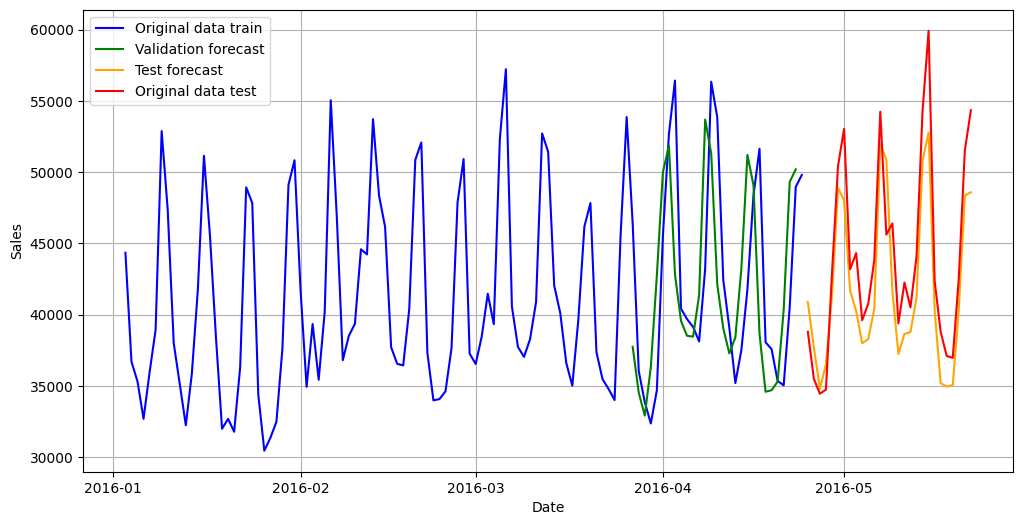

Validation error (RMSE): 1866.3655858378872
Test error (RMSE): 3288.076641442532


In [292]:
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def train_and_validate_xgb(X_train, X_val, y_train, y_val, param_ranges):
    """
    Entrena y valida modelos XGBRegressor con diferentes combinaciones de hiperparámetros.

    Args:
        X_train, y_train (pd.DataFrame): DataFrame con las features.
        x_val, y_val (pd.Series): Serie con la variable objetivo.
        param_ranges (dict): Diccionario con los rangos de valores de hiperparámetros a probar.

    Returns:
        dict: Información del mejor modelo (parámetros, error y el modelo en sí).
    """
    best_model_info = {"params": None, "rmse": float("inf"), "model": None}

    for n_estimators in param_ranges["n_estimators"]:
        for learning_rate in param_ranges["learning_rate"]:
            for max_depth in param_ranges["max_depth"]:
                for alpha in param_ranges["alpha"]:
                  params = {
                      "n_estimators": n_estimators,
                      "learning_rate": learning_rate,
                      "max_depth": max_depth,
                      "alpha": alpha
                  }

                  model = XGBRegressor(random_state=42, **params)
                  model.fit(X_train, y_train)

                  y_val_pred = model.predict(X_val)
                  rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

                  if rmse < best_model_info["rmse"]:
                      best_model_info = {"params": params, "rmse": rmse, "model": model}

    return best_model_info

def plot_forecast(best_model, X_val, y_val, fechas_futuras, fechas_val, total_sales_eval, dates):
    """
    Realiza el gráfico del modelo con menor error.

    Args:
        best_model (XGBRegressor): Modelo XGBRegressor con el menor error.
        X_val (pd.DataFrame): Conjunto de validación.
        y_val (pd.Series): Valores reales del conjunto de validación.
        fechas_futuras (pd.DataFrame): DataFrame con las features de las fechas futuras.
        fechas_val (pd.DataFrame): DataFrame con las fechas del conjunto de validación.
        total_sales_eval (pd.Series): Valores reales del conjunto de prueba para comparar.

    """
    y_val_pred = best_model.predict(X_val)
    future_predictions = best_model.predict(fechas_futuras)

    fechas_futuras['date'] = dates
    plt.figure(figsize=(12, 6))
    plt.plot(serie[1800:], label="Original data train", color="blue")
    plt.plot(fechas_val, y_val_pred, label="Validation forecast", color="green")
    plt.plot(fechas_futuras['date'], future_predictions, label="Test forecast", color="orange")
    plt.plot(fechas_futuras['date'], total_sales_eval[1913:], label="Original data test", color="red")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()

    test_rmse = np.sqrt(mean_squared_error(total_sales_eval[1913:], future_predictions))
    print(f"Validation error (RMSE): {best_model_info['rmse']}")
    print(f"Test error (RMSE): {test_rmse}")

# Ejemplo de uso:
# Definir los rangos de hiperparámetros a explorar
param_ranges = {
    "n_estimators": [270],
    "learning_rate": [0.1],
    "max_depth": [5],
    "alpha": [13]
}

# Obtener el mejor modelo
X = data.drop(columns="total_sales")
y = data["total_sales"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.0146, shuffle=False) # Más o menos el último mes de data como validation
best_model_info = train_and_validate_xgb(X_train, X_val, y_train, y_val, param_ranges)
print(f"Mejor modelo: {best_model_info}")

# Crear el dataframe con las mismas features que el train/test.
date_range = pd.date_range(start='2016-04-25', periods=28)
fechas_futuras = pd.DataFrame({
    'date': date_range,
    'wday': date_range.weekday + 3,  # Días de la semana (1=Lunes, 7=Domingo)
    'day': date_range.day,
    'month': date_range.month,
    'year': date_range.year
})

for i in fechas_futuras.index:
  if fechas_futuras.loc[i, 'wday'] >=8:
    fechas_futuras.loc[i, 'wday'] = fechas_futuras.loc[i, 'wday'] -7

for i in range(28):
  fechas_futuras.loc[i, 'event_name_1'] = calendar_reduced.loc[1546+i, 'event_name_1']
  fechas_futuras.loc[i, 'event_name_2'] = calendar_reduced.loc[1546+i, 'event_name_2']

fechas_futuras['event_name_1'] = fechas_futuras['event_name_1'].notna()
fechas_futuras['event_name_2'] = fechas_futuras['event_name_2'].notna()

# Limpiar columnas innecesarias
dates = fechas_futuras['date']
fechas_futuras = fechas_futuras.drop(columns=['date'])

date_range = pd.date_range(start='2016-03-27', periods=28)
fechas_val = pd.DataFrame({'date': date_range})

# Graficar las predicciones
plot_forecast(
    best_model_info["model"],
    X_val,
    y_val,
    fechas_futuras,
    fechas_val,
    total_sales_eval,
    dates
)


# ARIMA

In [293]:
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

modelo = auto_arima(serie, start_p=1, max_d=1, seasonal=True, m=14, trace=True, error_action='ignore', suppress_warnings=True, n_fits=50)
print(modelo.summary())

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [294]:
model_arima = ARIMA(serie, order=modelo.order, seasonal_order=modelo.seasonal_order).fit()
pronostico_arima = model_arima.forecast(steps=28)

plt.figure(figsize=(12, 6))
plt.plot(serie[1800:], label="Original data train", color="blue")
plt.plot(pronostico_arima, label="Test forecast", color="orange")
plt.plot(fechas_futuras['date'], total_sales_eval[1913:], label="Original data test", color="red")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

error = np.sqrt(mean_squared_error(total_sales_eval[1913:], pronostico_arima))
print("Test error:", str(error))

NameError: name 'modelo' is not defined

# DeepAR

In [254]:
train_sets, cv_sets = m5data.get_train_val_ts(n_splits=1, dynamic_start_pos=True)
test_set = m5data.get_test_ts()
# n_splits = len(train_sets)

# Training Data
training_dates = m5data.get_dates(train_sets[0])
training_df = pd.DataFrame({"sales": train_sets[0].values}, index=training_dates.values)
training_df.index.name = "Day" 
training_data = PandasDataset(training_df, freq="D", target="sales")

# Evaluation Data
eval_dates = m5data.get_dates(cv_sets[0])
eval_df = pd.DataFrame({"sales": cv_sets[0].values}, index=eval_dates.values)
eval_df.index.name = "Day" 

all_set = pd.concat([train_sets[0], cv_sets[0]])
all_dates = m5data.get_dates(all_set)
all_df = pd.DataFrame({"sales": all_set.values}, index=all_dates.values)
eval_data = PandasDataset(all_df, freq="D", target="sales")

# Test Data
test_dates = m5data.get_dates(test_set)
test_df = pd.DataFrame({"sales": test_set.values}, index=test_dates.values)
test_df.index.name = "Day" 

aux = next(iter(training_data))
len(aux['target'])


984

In [285]:
model_path = "./models/DeepAR_v0.3"

# Train the model if a model path is not set
if os.path.exists(model_path):
    model = Predictor.deserialize(Path(model_path))
else:
    lags_sequence = get_lags_for_frequency(training_data.freq)
    lags_sequence = None
    model = DeepAREstimator(
        prediction_length=28, freq="D", trainer_kwargs={"max_epochs": 100}, lags_seq=lags_sequence
    ).train(training_data=training_data, validation_data=eval_data)
    
    os.mkdir(model_path)
    model.serialize(Path(model_path))

/home/ag6154lk/KISA_ITSDA/.venv/lib/python3.12/site-packages/gluonts/torch/model/predictor.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


<Figure size 640x480 with 0 Axes>

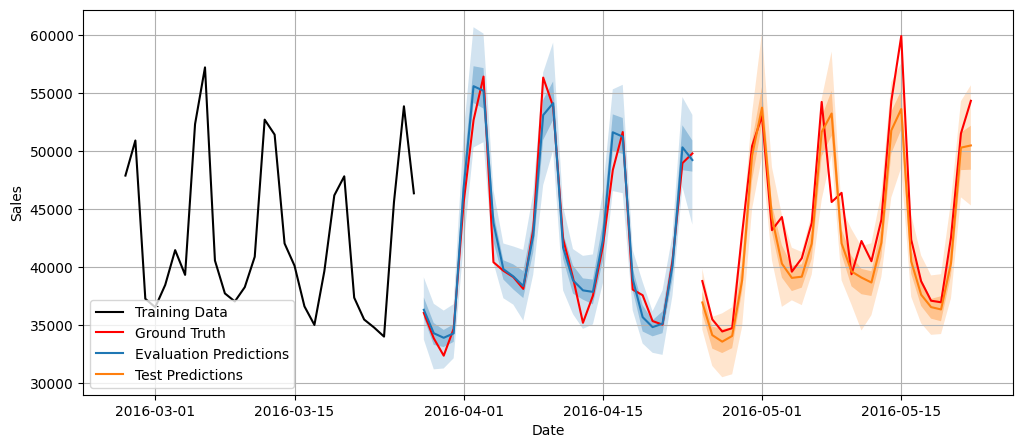

In [286]:
val_forecast   = list(model.predict(training_data))[0]
test_forecast  = list(model.predict(eval_data))[0]

# Plot predictions
plt.tight_layout()
plt.figure(figsize=(12, 5))
plt.plot(training_df.index[-30:], training_df.values[-30:], color="black", label = "Training Data")
plt.plot(eval_df.index, eval_df.values, color = "red", label = "Ground Truth")
plt.plot(test_df.index, test_df.values, color = "red")

val_forecast.plot(name="Evaluation Predictions")
test_forecast.plot(name="Test Predictions")

#plt.legend(["Training Data", "Ground Truth", "Ground Truth", "Evaluation Predictions", None, None, "Test Predictions"], loc="lower left")
plt.legend(loc = "lower left")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [288]:
val_error   = np.sqrt(mean_squared_error(eval_df.values, val_forecast.mean))
test_error  = np.sqrt(mean_squared_error(test_df.values, test_forecast.mean))
print(f"Validation error (RMSE): {val_error}")
print(f"Test error (RMSE): {test_error}")

Validation error (RMSE): 1549.2573220740317
Test error (RMSE): 2887.179159664325


# Time Series Transformer

In [247]:
from datasets import Dataset
from transformers import TimeSeriesTransformerForPrediction, TimeSeriesTransformerConfig, Trainer, TrainingArguments

# Convierte los datasets de GluonTS a un formato compatible con Hugging Face
def create_sliding_windows_from_pandasdataset(dataset, prediction_length, context_length):
    """
    Genera ventanas deslizantes a partir de un PandasDataset de GluonTS.

    Args:
        dataset (PandasDataset): El dataset de GluonTS.
        prediction_length (int): Tamaño de la ventana de predicción.
        context_length (int): Tamaño del contexto histórico.

    Returns:
        Dataset: Ventanas en formato Dataset de Hugging Face.
    """
    windows = []

    for item in dataset:
        target = item["target"]
        start_date = item["start"]
        
        total_length = len(target)

        if total_length < context_length + prediction_length:
            continue 

        # Crear ventanas deslizantes para esta serie temporal
        for start in range(total_length - context_length - prediction_length + 1):
            end_context = start + context_length
            end_future = end_context + prediction_length

            past_values = target[start:end_context]
            future_values = target[end_context:end_future]

            # Crear características temporales para la ventana de contexto (pasado)
            past_time_features = []
            for i in range(context_length):
                date = start_date + pd.Timedelta(days=i)
                past_time_features.append([date.day, date.month, date.year])

            # Convertir las características de tiempo a una matriz de numpy
            past_time_features = np.array(past_time_features)

            # Crear características temporales para la ventana futura (predicción)
            future_time_features = []
            for i in range(prediction_length):
                date = start_date + pd.Timedelta(days=(context_length + i))
                future_time_features.append([date.day, date.month, date.year])

            # Convertir las características de tiempo futuras a una matriz de numpy
            future_time_features = np.array(future_time_features)

            # Crear las máscaras de observación (suponemos que todos los valores son observados)
            past_observed_mask = np.ones(context_length)
            future_observed_mask = np.ones(prediction_length)

            # Agregar la ventana a la lista de ventanas
            windows.append({
                "past_values": past_values,
                "future_values": future_values,
                "past_time_features": past_time_features,
                "future_time_features": future_time_features,
                "past_observed_mask": past_observed_mask,
                "future_observed_mask": future_observed_mask,
            })
    
    return Dataset.from_list(windows)

# Convertir los datasets
context_length = 84
prediction_length = 28
hf_training_data    = create_sliding_windows_from_pandasdataset(training_data, prediction_length, context_length)
hf_eval_data        =  create_sliding_windows_from_pandasdataset(eval_data, prediction_length, context_length)

# Verificar el tamaño del dataset
print(f"Número de ventanas generadas: {len(hf_training_data)}")
for i, record in enumerate(hf_training_data):
    print(f"Registro {i}:")
    for k, v in record.items():
        print(f"    {k}: {v}")
    print()
    
    assert len(record['past_values']) == len(record['past_time_features'])
    assert len(record['past_values']) == len(record['past_observed_mask'])
    assert len(record['future_values']) == len(record['future_time_features'])
    assert len(record['future_values']) == len(record['future_observed_mask'])
    break

Número de ventanas generadas: 873
Registro 0:
    past_values: [33921, 36194, 41527, 42039, 32203, 31304, 31468, 31816, 36843, 41672, 40480, 31763, 30162, 31255, 37309, 41663, 47105, 44439, 39149, 36694, 35079, 34886, 40699, 44912, 47520, 38753, 35144, 33732, 37643, 38025, 44431, 44894, 35237, 31625, 32633, 31793, 37113, 44836, 48577, 34200, 32963, 32456, 31710, 41621, 47972, 44741, 47072, 37799, 33328, 35425, 38684, 47600, 51740, 39765, 34663, 36195, 36767, 40971, 49166, 50970, 36775, 32571, 31281, 30823, 36281, 46001, 46210, 32784, 31064, 29959, 30648, 35502, 44441, 44396, 32893, 36730, 33900, 37215, 37334, 48777, 49888, 37003, 34544, 34746]
    future_values: [34019, 38093, 46581, 46343, 36836, 33213, 32677, 30538, 34337, 42043, 43352, 31859, 28957, 29525, 29260, 33877, 42454, 40665, 32058, 29529, 31136, 27034, 39727, 47093, 48373, 32972, 34087, 33030]
    past_time_features: [[18, 7, 2013], [19, 7, 2013], [20, 7, 2013], [21, 7, 2013], [22, 7, 2013], [23, 7, 2013], [24, 7, 2013], [2

In [264]:

lags_sequence = get_lags_for_frequency(training_data.freq)
#lags_sequence = [1, 7, 30] # días, semanas, meses
print(lags_sequence)

# Configurar el modelo
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=context_length,
    lags_sequence=lags_sequence,
    input_size=1,  # Una variable por entrada
    num_time_features=3,  # día, mes, año
    num_static_categorical_features=0,
    num_static_real_features=0,
)
model = TimeSeriesTransformerForPrediction(config)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_training_data,
    eval_dataset=hf_training_data
)
trainer.train() # Entrenar el modelo

[1, 3]


/home/ag6154lk/KISA_ITSDA/.venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 0/8730 [00:00<?, ?it/s]

ValueError: lags cannot go further than history length, found lag 3 while history length is only 112